노래의 특징(댄스 가능성, 라이브성, 음량, 에너지)을 바탕으로 노래가 히트할지 안할지 예측한다

- 데이터 전처리, 머신러닝(모델 선택), 시각화
- 회귀 : 수치 예측
- 앙상블 : 여러 모델들을 혼합해 사용
- GridSearch : 하이퍼파라미터 자동 최적화

데이터셋
Kaggle 데이터셋 : https://www.kaggle.com/datasets/yasserh/song-popularity-

진행목차
1. 데이터 불러오기
2. 데이터 분석(EDA)
3. 데이터 전처리
4. 인기 예측 회귀모델
5. 성능 분석
6. 회귀 모델 고도화

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl        # 시각화도구(시각화옵션, 폰트설정)
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('font', family='NanumGothic')    # 한글 폰트 설정

In [11]:
# 노래 데이터 가져오기
df = pd.read_csv("data/song_data.csv",encoding='utf-8')

target = 'song_popularity' # 타겟 변수 (노래 인기도)

### 타겟 (종속 변수)
- song_popularity : 인기점수 (0점~100점)

### 특징(독립 변수_)
|특성명|설명|범위/값|
|----|----|-------|
| song_name|트랙제목|
| song_duration_ms|  노래길이 |(밀리초 단위)
| acousticness|  어쿠스틱 노래 가능성 |(0~1)
| song_name|  트랙 제목
| danceability|  노래에 춤추기 적합한 정도 |(0~0.99)
| energy|  노래의 에너지 강도 |(0~1.0)
| instrumentalness|  노래에 보컬이 없을 가능성|(0~1.0)
| key|  음악 키|(0 = C, 11 = B, 0~11)
| liveness|  라이브 관객의 존재 추정|(0.01~0.99)
| loudness|  음량 레벨 |( -38.8~1.58)
| audio_mode|  조성|(1:장조, 0:단조)
| speechiness|  발화된 단어가 존재할 가능성|(0.0~0.94)
| tempo|  분당 박자|(BPM)
| time_signature|  음악 한 마디의 박자 |(0~5)
| audio_valance|  트랙의 긍정성 또는 쾌활함 |( 0.0~0.98)

In [20]:
df.drop(["song_name"],axis=1, inplace=True)     # song_name 열은 사용하지 않아 삭제

In [21]:
feature = [i for i in df.columns if i not in [target]]  # 특성 피터링
original_df = df.copy(deep=True)    # 데이터 원본 보존 깊은 복사

print(df.shape)
print(f"이 데이터셋에는 {df.shape[1]}개의 특성과 {df.shape[0]}의 샘플로 구성되어 있다.")

(18835, 14)
이 데이터셋에는 14개의 특성과 18835의 샘플로 구성되어 있다.


# 탐색적 데이터 분석(EDA)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [24]:
# 숫자형, 범주형 특징 식별
nu = df[feature].nunique().sort_values()    # 각 특성별로 고유값(카테고리) 갯수 계산 후 정렬
nf = [] # 숫자형 특성 리스트
cf = [] # 범주형 특성 리스트
nnf = 0 # 숫자형 특성 갯수
ncf = 0 # 범주형 특성 갯수

# nu

# 16개 미만의 값을 가진 특징은 범주형으로 간주한다.
for i in range(df[feature].shape[1]):
    if nu.values[i] <= 16:
        cf.append(nu.index[i])
    else :
        nf.append(nu.index[i])
print(f"이 데이터셋은 {len(nf)}개의 숫자형, {len(cf)}개의 범주형 특성을 가지고 있다.")
print(f"범주형 특성: {cf}")
print(f"숫자형 특성: {nf}")

이 데이터셋은 10개의 숫자형, 3개의 범주형 특성을 가지고 있다.
범주형 특성: ['audio_mode', 'time_signature', 'key']
숫자형 특성: ['danceability', 'energy', 'speechiness', 'audio_valence', 'liveness', 'acousticness', 'instrumentalness', 'loudness', 'song_duration_ms', 'tempo']


In [25]:
df['song_popularity']

0        73
1        66
2        76
3        74
4        56
         ..
18830    60
18831    60
18832    23
18833    55
18834    60
Name: song_popularity, Length: 18835, dtype: int64

In [ ]:
df[nf].describe().T # 통계량을 행이 아닌 컬럼별로 한줄씩 보이게 한다.

,count,mean,std,min,25%,50%,75%,max
danceability,18835.0,0.633348,0.156723,0.000000,0.5330,0.645000,0.74800,0.987
energy,18835.0,0.644995,0.214101,0.001070,0.5100,0.674000,0.81500,0.999
speechiness,18835.0,0.102099,0.104378,0.000000,0.0378,0.055500,0.11900,0.941
audio_valence,18835.0,0.527967,0.244632,0.000000,0.3350,0.527000,0.72500,0.984
liveness,18835.0,0.179650,0.143984,0.010900,0.0929,0.122000,0.22100,0.986
acousticness,18835.0,0.258539,0.288719,0.000001,0.0241,0.132000,0.42400,0.996
instrumentalness,18835.0,0.078008,0.221591,0.000000,0.0000,0.000011,0.00257,0.997
loudness,18835.0,-7.447435,3.827831,-38.768000,-9.0440,-6.555000,-4.90800,1.585
song_duration_ms,18835.0,218211.587576,59887.540566,12000.000000,184339.5000,211306.000000,242844.00000,1799346.000
tempo,18835.0,121.073154,28.714456,0.000000,98.3680,120.013000,139.93100,242.318


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
c:\Users\Playdata\ml\ml_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\ml\ml_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
c:\Users\Playdata\ml\ml_venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\Playdata\ml\ml_venv\Lib\site-packages\IPython\core\events.py:96: Us

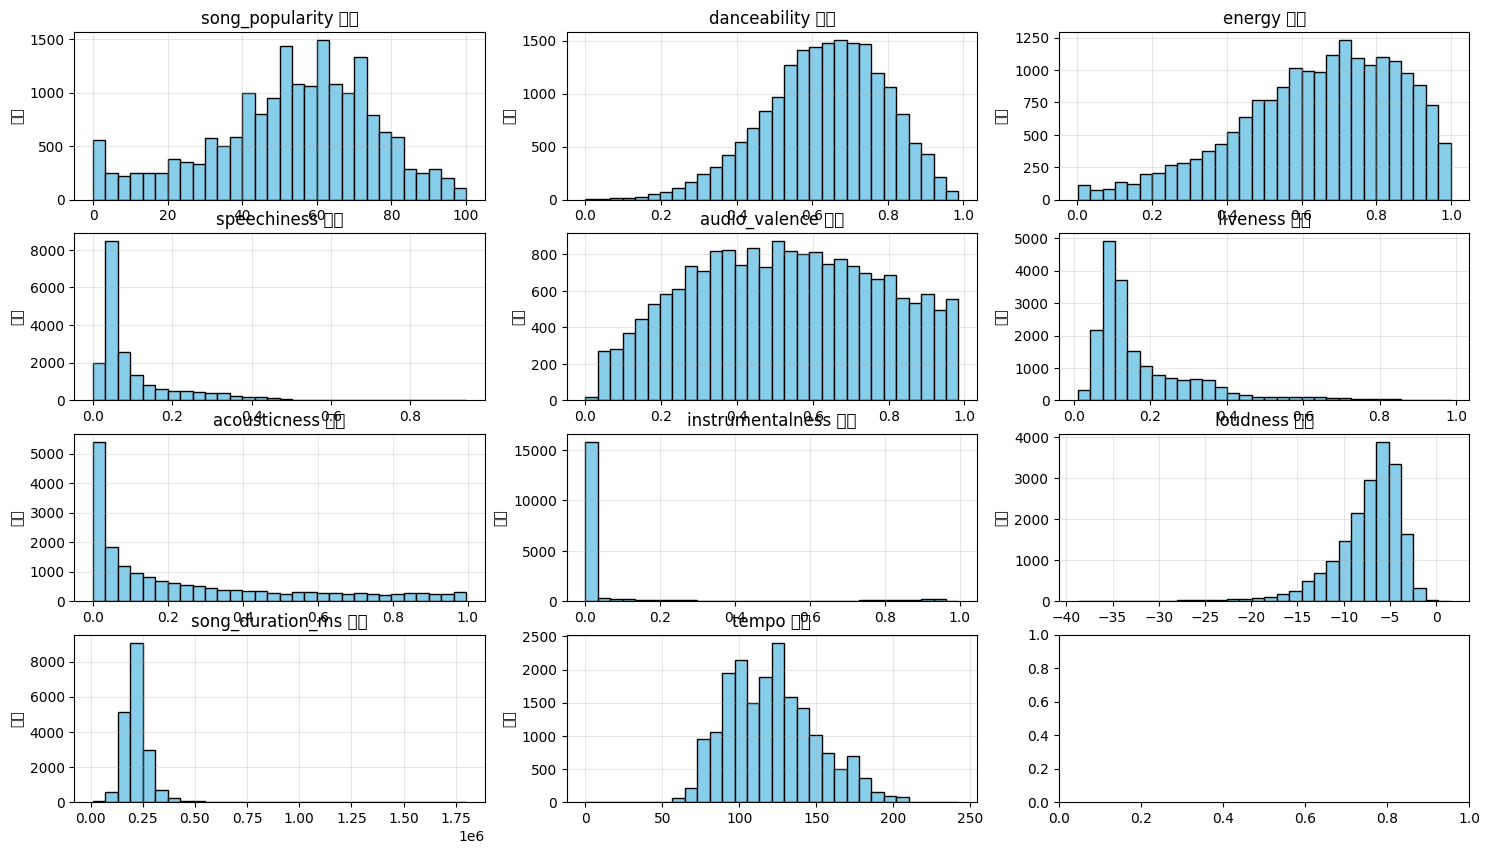

In [33]:
# 수치형 변수의 분포
columns = [target] + nf # 타겟(인기도)와 숫자형 특성들 리스트

fig, axes = plt.subplots(4,3, figsize = (18,10)) # 4행 3열의 서브플롯(그래프) 생성

for idx, col in enumerate(columns):
    row = idx // 3      # 몇번쨰 행에 그릴지 결정
    col_idx = idx % 3   # 몇번쨰 열에 그릴지 결정
    axes[row][col_idx].hist(
        df[col].dropna(),
        bins=30,
        color='skyblue',
        edgecolor='black')
    axes[row][col_idx].set_title(f"{col} 분포")
    axes[row][col_idx].set_ylabel('빈도')
    axes[row][col_idx].grid(alpha=0.3)  # 격자(그리드) 표시